In [1]:
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csv
import numpy as np
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
## File import from gdrive
data = pd.read_csv('gdrive/My Drive/AzureFunctionsInvocation.csv')

## Adding counter to the column
data['counter'] = range(1,len(data)+1)

## ADDING START TIMESTAMP
data['st_tsp'] = (data['end_timestamp']-data['duration'])

## Setting the start date
init_date = '2021-01-31'
start_time = '00:00:00.0'

## creating new column wait_delay
start_date = datetime.strptime(init_date + ' ' + start_time, "%Y-%m-%d %H:%M:%S.%f")
data['d_t'] = start_date + pd.TimedeltaIndex(data['st_tsp'], unit='s')
data['date'] = data['d_t']
data = data.set_index('d_t')
data['dt_num'] = pd.to_datetime(data['date'])
data['dt_num'] = data['dt_num'].map(datetime.timestamp)
data['wait_delay'] = round(data['st_tsp'].diff()*1000,0)
data.wait_delay = data.wait_delay.fillna(0).astype(int)



<ipython-input-2-f37de84da907>:16: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  data['d_t'] = start_date + pd.TimedeltaIndex(data['st_tsp'], unit='s')


In [3]:
## From the dataset choosing 2021-02-01 10:00 - 14:00

main_df_1 = data.copy()
lr_date_obj = datetime.strptime('2021-02-01 10', "%Y-%m-%d %H")
lr_end_date_obj = datetime.strptime('2021-02-01 14', "%Y-%m-%d %H")
mask = (main_df_1['date'] > lr_date_obj) & (main_df_1['date'] <= lr_end_date_obj)
main_df_1 = main_df_1.loc[mask]




<Axes: >

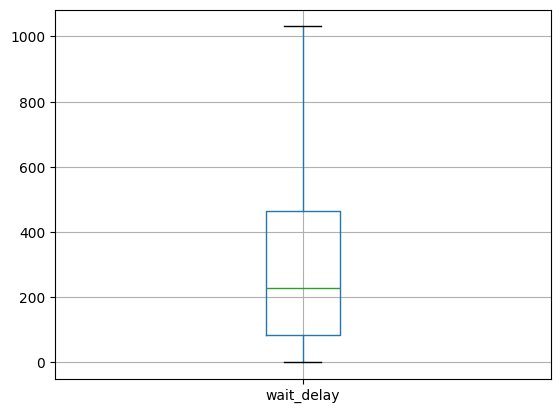

In [4]:
## Removing Outliers

def ITR(df_):
  for x in ['wait_delay']:
      p75,p25 = np.percentile(df_.loc[:,x],[75,25])
      intr_qr = p75-p25

      max = p75+(1.5*intr_qr)
      min = p25-(1.5*intr_qr)

      df_.loc[df_[x] < min,x] = np.nan
      df_.loc[df_[x] > max,x] = np.nan

  df_ = df_.dropna(axis = 0)
  df_.isnull().sum()
  return df_

previous_shape = None
current_shape = main_df_1.shape
while previous_shape != current_shape:
    previous_shape = current_shape
    main_df_1 = ITR(main_df_1)
    current_shape = main_df_1.shape

## Boxplot for wait_delay column
main_df_1.boxplot(['wait_delay'])

In [5]:
## Creating Data set for Jmeter
main_df_cp = main_df_1.copy()
## Dropping columns and sampling down the dataset
main_df_cp = main_df_cp.drop(['counter', 'dt_num', 'wait_delay'], axis=1)

main_df_cp = main_df_cp[::5]


main_df_cp = main_df_cp[::4]

value_counts = main_df_cp['func'].value_counts()

## setting func column to top common occurence
main_df_cp['func'] = '155e47f8e7f751d0c845049456d01832013c61336a8cd85901330ac821a71534'

## updating the counter and calulating wait delay
main_df_cp['counter'] = range(1,len(main_df_cp)+1)
main_df_cp['wait_delay'] = round(main_df_cp['st_tsp'].diff()*1000,0)
main_df_cp.wait_delay = main_df_cp.wait_delay.fillna(0).astype(int)


In [ ]:
## save the file to csv in drive
main_df_cp.to_csv('gdrive/My Drive/Openwhisk_AzureDataset.csv', sep=',', encoding='utf-8')

##Predictive Model

<Axes: >

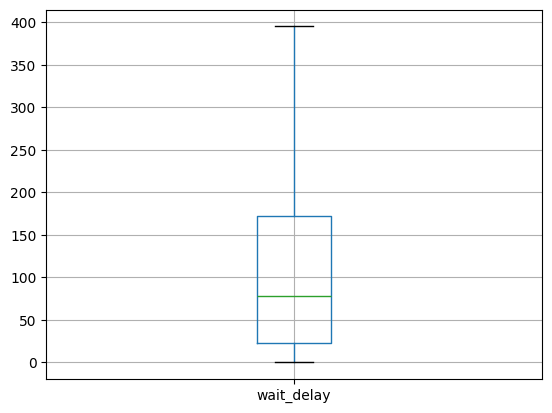

In [6]:
## Linear Regression
train_df = data.copy()
train_st_date_obj = datetime.strptime('2021-01-31', "%Y-%m-%d")
train_end_date_obj = datetime.strptime('2021-02-04 18', "%Y-%m-%d %H")
# setting test count
end_temp = train_end_date_obj - timedelta(hours=6)
test_df = (train_df['date'] > end_temp) & (train_df['date'] <= train_end_date_obj)
t_ct = len(train_df.loc[test_df])

wrap = (train_df['date'] > train_st_date_obj) & (train_df['date'] <= train_end_date_obj)
train_df = train_df.loc[wrap]
train_df.shape

## Removing Outliers
previous_shape = None
current_shape = train_df.shape
while previous_shape != current_shape:

    previous_shape = current_shape
    train_df = ITR(train_df)
    current_shape = train_df.shape
train_df.boxplot(['wait_delay'])

In [7]:
evts = train_df['counter']
time = train_df['dt_num']
train_df.describe()

,end_timestamp,duration,counter,st_tsp,date,dt_num,wait_delay
count,679545.000000,679545.000000,679545.000000,679545.000000,679545,6.795450e+05,679545.000000
mean,235097.544004,2.340505,474144.643929,235095.203499,2021-02-02 17:18:15.203499008,1.612286e+09,110.825547
min,0.066824,0.000000,1.000000,0.001491,2021-01-31 00:00:00.001490900,1.612051e+09,0.000000
25%,166020.154769,0.001000,254422.000000,166020.112769,2021-02-01 22:07:00.112769024,1.612217e+09,23.000000
50%,246693.775041,0.031000,485803.000000,246687.300146,2021-02-02 20:31:27.300146176,1.612298e+09,78.000000
75%,320463.374243,0.305000,698923.000000,320460.905528,2021-02-03 17:01:00.905528064,1.612372e+09,172.000000
max,410370.351278,578.620000,913840.000000,410370.258278,2021-02-04 17:59:30.258278067,1.612462e+09,395.000000
std,92180.364197,19.275045,255118.168569,92181.433870,NaN,9.218143e+04,106.044438


In [8]:
events_np = evts.to_numpy().reshape(-1, 1)
time_np = time.to_numpy()

# Create and fit the model
model = LinearRegression()
model.fit(events_np, time_np)

# Get the estimated parameters
alpha_hat = model.intercept_
beta_hat = model.coef_[0]

# Make predictions
predictions = model.predict(events_np)

# Calculate MSE and MAE
mse = mean_squared_error(events_np, predictions)
mae = mean_absolute_error(events_np, predictions)

print(f'alpha_hat: {alpha_hat}')
print(f'beta_hat: {beta_hat}')
print(f'MSE: {mse}')
print(f'MAE: {mae}')

alpha_hat: 1612117860.0134578
beta_hat: 0.35524009855937816
MSE: 2.597938435748373e+18
MAE: 1611812150.5595696


In [9]:
## Ploting
# print(t_ct)
# Plotting
n_predictions = t_ct
s = [1**n for n in range(len(evts))]
s_predictions = [1**n for n in range(n_predictions)]


# Generate future predictions
future_events = np.arange(events_np.max() + 1, events_np.max() + 1 + n_predictions).reshape(-1, 1)
future_predictions = model.predict(future_events)





In [10]:
linearRegression = pd.DataFrame(future_predictions, columns=['Predictions'])

# Calculate 'wait' column
linearRegression['wait_delay'] = round(linearRegression['Predictions'].diff() * 1000, 0)
linearRegression['wait_delay'] = linearRegression['wait_delay'].fillna(linearRegression['wait_delay'][1])

# Display the last few rows of the DataFrame
print(linearRegression.tail())

        Predictions  wait_delay
24497  1.612451e+09       355.0
24498  1.612451e+09       355.0
24499  1.612451e+09       355.0
24500  1.612451e+09       355.0
24501  1.612451e+09       355.0


In [11]:
lR_copy = (linearRegression['wait_delay']*20).astype(int)
lR_copy = lR_copy[::5]
lR_copy = lR_copy[::4]
lR_copy.tail()
# lR_copy.to_csv('gdrive/My Drive/Colab Notebooks/lr_wait_delays.csv', sep=',', encoding='utf-8')

,wait_delay
24420,7100
24440,7100
24460,7100
24480,7100
24500,7100


## 2 Algorithm

In [12]:
## creating main data from data var

main_2_df = data.copy()
print(main_2_df.shape)
nn_date_obj = datetime.strptime('2021-02-04 12', "%Y-%m-%d %H")
nn_end_date_obj = datetime.strptime('2021-02-04 18', "%Y-%m-%d %H")
warp2 = (main_2_df['date'] > nn_date_obj) & (main_2_df['date'] <= nn_end_date_obj)
main_2_df = main_2_df.loc[warp2]
main_2_df.shape

(999999, 9)


(24502, 9)

<Axes: >

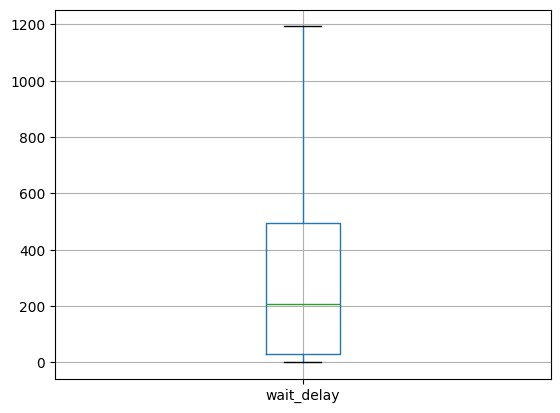

In [13]:
previous_shape = None
current_shape = main_2_df.shape
while previous_shape != current_shape:
    previous_shape = current_shape
    main_2_df = ITR(main_2_df)
    current_shape = main_2_df.shape
main_2_df.boxplot(['wait_delay'])

In [14]:
## Dataset for Azure

main_2_df = main_2_df.copy()
main_2_df = main_2_df.drop(['counter', 'dt_num', 'wait_delay'], axis=1)
main_2_df = main_2_df[::5]
main_2_df = main_2_df[::4]
main_2_df['func'] = '155e47f8e7f751d0c845049456d01832013c61336a8cd85901330ac821a71534'
main_2_df['counter'] = range(1,len(main_2_df)+1)
main_2_df['wait_delay'] = round(main_2_df['st_tsp'].diff()*1000,0)
main_2_df.wait_delay = main_2_df.wait_delay.fillna(0).astype(int)


In [ ]:
## Dataset for Azure

main_2_df.to_csv('gdrive/My Drive/ML_AzureDataset.csv', sep=',', encoding='utf-8')


In [15]:
train_df_2 = data.copy()
start_obj_nn = datetime.strptime('2021-01-31', "%Y-%m-%d")
end_obj_nn = datetime.strptime('2021-02-12 18', "%Y-%m-%d %H")
mask = (train_df_2['date'] > start_obj_nn) & (train_df_2['date'] <= end_obj_nn)
train_df_2 = train_df_2.loc[mask]


<Axes: >

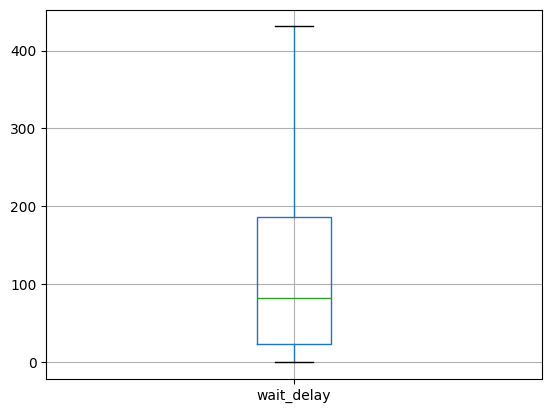

In [16]:
previous_shape = None
current_shape = train_df_2.shape
while previous_shape != current_shape:

    previous_shape = current_shape
    train_df_2 = ITR(train_df_2)
    current_shape = train_df_2.shape
train_df_2.boxplot(['wait_delay'])

In [17]:
## Neural Network

train_df_2 = train_df_2[['wait_delay','dt_num']]
train_df_2['hour'] = train_df_2.index.hour
train_df_2['day'] = train_df_2.index.day

train_df_2.tail()
train_df_2['minute'] = train_df_2.index.minute

# Day
train_df_2['dd_sin'] = np.sin(train_df_2['day'] * (2. * np.pi / 30))
train_df_2['dd_cos'] = np.cos(train_df_2['day'] * (2. * np.pi / 30))
# Hour
train_df_2['hh_sin'] = np.sin(train_df_2['hour'] * (2. * np.pi / 24))
train_df_2['hh_cos'] = np.cos(train_df_2['hour'] * (2. * np.pi / 24))
# Minute
train_df_2['mm_sin'] = np.sin(train_df_2['minute'] * (2. * np.pi / 60))
train_df_2['mm_cos'] = np.cos(train_df_2['minute'] * (2. * np.pi / 60))

# Drop the original columns
train_df_2 = train_df_2.drop(['hour', 'day', 'minute', 'dt_num'], axis=1)






<ipython-input-17-2ac45c4db144>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_2['hour'] = train_df_2.index.hour
<ipython-input-17-2ac45c4db144>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_2['day'] = train_df_2.index.day
<ipython-input-17-2ac45c4db144>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [18]:
train_df_2_np = train_df_2.to_numpy()

# Define window size
WINDOW_SIZE = 20

# Create TimeseriesGenerator
generator = TimeseriesGenerator(train_df_2_np, train_df_2_np[:, 0], length=WINDOW_SIZE, batch_size=len(train_df_2_np))

# Extract X and y
X2, y2 = generator[0]
X2.shape, y2.shape

((744528, 20, 7), (744528,))

In [19]:
X_train2, y_train2 = X2[:700000], y2[:700000]
X_val2, y_val2 = X2[620000:660000], y2[620000:660000]
X_test2, y_test2 = X2[660000:700000], y2[660000:700000]
X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

((700000, 20, 7),
 (700000,),
 (40000, 20, 7),
 (40000,),
 (40000, 20, 7),
 (40000,))

In [20]:
# Normalize the data
temp_training_mean = np.mean(X_train2[:, :, 0])
temp_training_std = np.std(X_train2[:, :, 0])

def preprocessing(X):
    X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
    return X

X_train2 = preprocessing(X_train2)
X_val2 = preprocessing(X_val2)
X_test2 = preprocessing(X_test2)

X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

((700000, 20, 7),
 (700000,),
 (40000, 20, 7),
 (40000,),
 (40000, 20, 7),
 (40000,))

In [21]:
LSTMmodel = Sequential()
LSTMmodel.add(InputLayer((X_train2.shape[1],X_train2.shape[2])))
LSTMmodel.add(LSTM(units=64, activation='relu', stateful=False))
LSTMmodel.add(Dense(8, 'relu'))
LSTMmodel.add(Dense(1, 'linear'))
LSTMmodel.summary()

LSTMcp = ModelCheckpoint('model1/lstm.keras', save_best_only=True)
LSTMmodel.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,961 (74.07 KB)

 Trainable params: 18,961 (74.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
LSTMmodel.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=5, callbacks=[LSTMcp])
LSTMmodel = load_model('model1/lstm.keras')

Epoch 1/5
21875/21875 ━━━━━━━━━━━━━━━━━━━━ 227s 10ms/step - loss: 11603.4424 - root_mean_squared_error: 107.6580 - val_loss: 33820.8164 - val_root_mean_squared_error: 183.9044
Epoch 2/5
21875/21875 ━━━━━━━━━━━━━━━━━━━━ 218s 10ms/step - loss: 10848.2959 - root_mean_squared_error: 104.1549 - val_loss: 33323.8047 - val_root_mean_squared_error: 182.5481
Epoch 3/5
21875/21875 ━━━━━━━━━━━━━━━━━━━━ 264s 10ms/step - loss: 10743.7637 - root_mean_squared_error: 103.6517 - val_loss: 35311.0547 - val_root_mean_squared_error: 187.9124
Epoch 4/5
21875/21875 ━━━━━━━━━━━━━━━━━━━━ 220s 10ms/step - loss: 10690.1992 - root_mean_squared_error: 103.3932 - val_loss: 31261.3594 - val_root_mean_squared_error: 176.8088
Epoch 5/5
21875/21875 ━━━━━━━━━━━━━━━━━━━━ 263s 10ms/step - loss: 10688.3945 - root_mean_squared_error: 103.3840 - val_loss: 32780.4688 - val_root_mean_squared_error: 181.0538


21875/21875 ━━━━━━━━━━━━━━━━━━━━ 105s 5ms/step


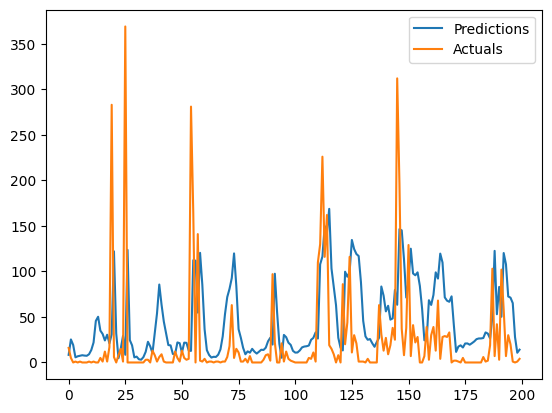

In [ ]:
train_predictions_LSTM = LSTMmodel.predict(X_train2).flatten()
train_results_LSTM = pd.DataFrame(data={'Train Predictions':abs(train_predictions_LSTM), 'Actuals':y_train2})
plt.plot(train_results_LSTM['Train Predictions'][:200],label="Predictions")
plt.plot(train_results_LSTM['Actuals'][:200],label="Actuals")
plt.legend(loc="upper right")

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step


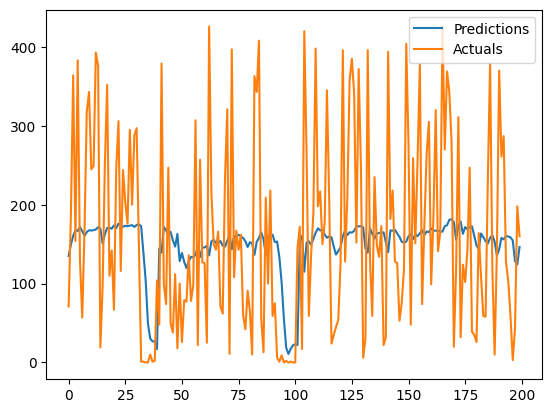

In [ ]:
test_predictions1 = LSTMmodel.predict(X_test2).flatten()
test_results1 = pd.DataFrame(data={'Test Predictions':abs(test_predictions1), 'Actuals':y_test2})
plt.plot(test_results1['Test Predictions'][:200],label="Predictions")
plt.plot(test_results1['Actuals'][:200],label="Actuals")
plt.legend(loc="upper right")

In [23]:
GRUmodel = Sequential()
GRUmodel.add(InputLayer((X_train2.shape[1],X_train2.shape[2])))
GRUmodel.add(GRU(units=64, activation='relu', stateful=False))
GRUmodel.add(Dense(8, 'relu'))
GRUmodel.add(Dense(1, 'linear'))
GRUmodel.summary()

GRUcp = ModelCheckpoint('model2/GRU.keras', save_best_only=True)
GRUmodel.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 64)                  │          14,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,545 (56.82 KB)

 Trainable params: 14,545 (56.82 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
GRUmodel.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=5, callbacks=[GRUcp])

Epoch 1/5
21875/21875 ━━━━━━━━━━━━━━━━━━━━ 252s 11ms/step - loss: 11720.6143 - root_mean_squared_error: 108.1953 - val_loss: 6783.0586 - val_root_mean_squared_error: 82.3593
Epoch 2/5
21875/21875 ━━━━━━━━━━━━━━━━━━━━ 257s 11ms/step - loss: 10983.1729 - root_mean_squared_error: 104.8004 - val_loss: 6751.0850 - val_root_mean_squared_error: 82.1650
Epoch 3/5
21875/21875 ━━━━━━━━━━━━━━━━━━━━ 264s 11ms/step - loss: 10907.4092 - root_mean_squared_error: 104.4382 - val_loss: 6705.9712 - val_root_mean_squared_error: 81.8900
Epoch 4/5
21875/21875 ━━━━━━━━━━━━━━━━━━━━ 251s 11ms/step - loss: 10868.6289 - root_mean_squared_error: 104.2519 - val_loss: 6729.4209 - val_root_mean_squared_error: 82.0331
Epoch 5/5
21875/21875 ━━━━━━━━━━━━━━━━━━━━ 249s 11ms/step - loss: 10822.5264 - root_mean_squared_error: 104.0309 - val_loss: 6524.2026 - val_root_mean_squared_error: 80.7725


In [25]:
GRUmodel = load_model('model2/GRU.keras')

21875/21875 ━━━━━━━━━━━━━━━━━━━━ 95s 4ms/step


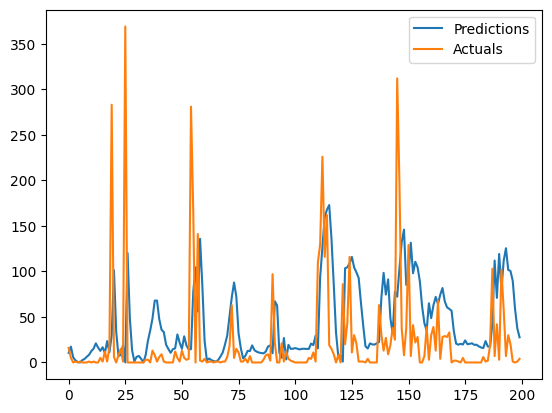

In [26]:
train_predictions_GRU = GRUmodel.predict(X_train2).flatten()
train_results_GRU = pd.DataFrame(data={'Train Predictions':abs(train_predictions_GRU), 'Actuals':y_train2})


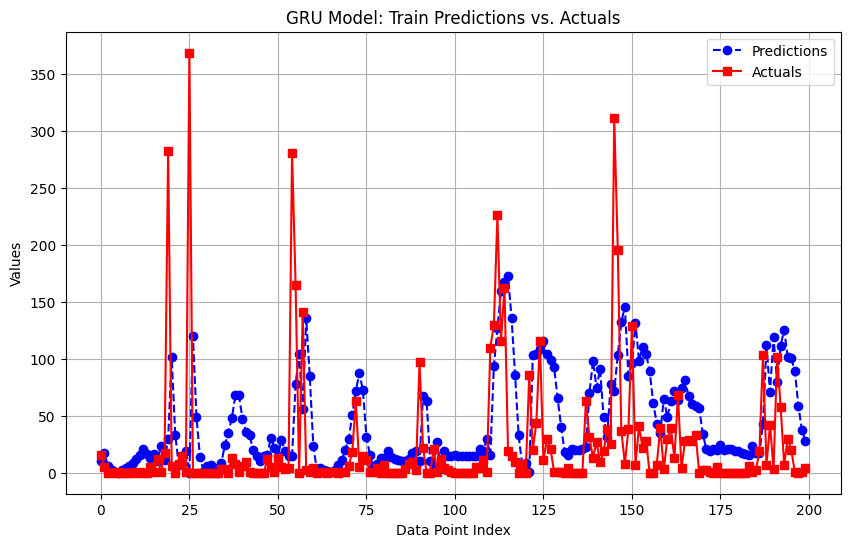

In [37]:
plt.figure(figsize=(10, 6))


plt.plot(train_results_GRU['Train Predictions'][:200], label="Predictions", linestyle='--', color='blue', marker='o')
plt.plot(train_results_GRU['Actuals'][:200], label="Actuals", linestyle='-', color='red', marker='s')

plt.legend(loc="upper right")
plt.grid(True)

plt.title("GRU Model: Train Predictions vs. Actuals")
plt.xlabel("Data Point Index")
plt.ylabel("Values")

plt.show()



In [38]:
test_predictions_GRU = GRUmodel.predict(X_test2).flatten()
test_results_GRU = pd.DataFrame(data={'wait_delay':abs(test_predictions_GRU), 'Actuals':y_test2})


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step


In [ ]:
test_resultsGRU_cp = (test_results_GRU['wait_delay']*60).astype(int)
test_resultsGRU_cp = test_resultsGRU_cp[::6]
test_resultsGRU_cp = test_resultsGRU_cp[::5]

test_resultsGRU_cp.to_csv('gdrive/My Drive/ML_Delays.csv', sep=',', encoding='utf-8')